In [1]:
import time
notebook_start_time = time.time()

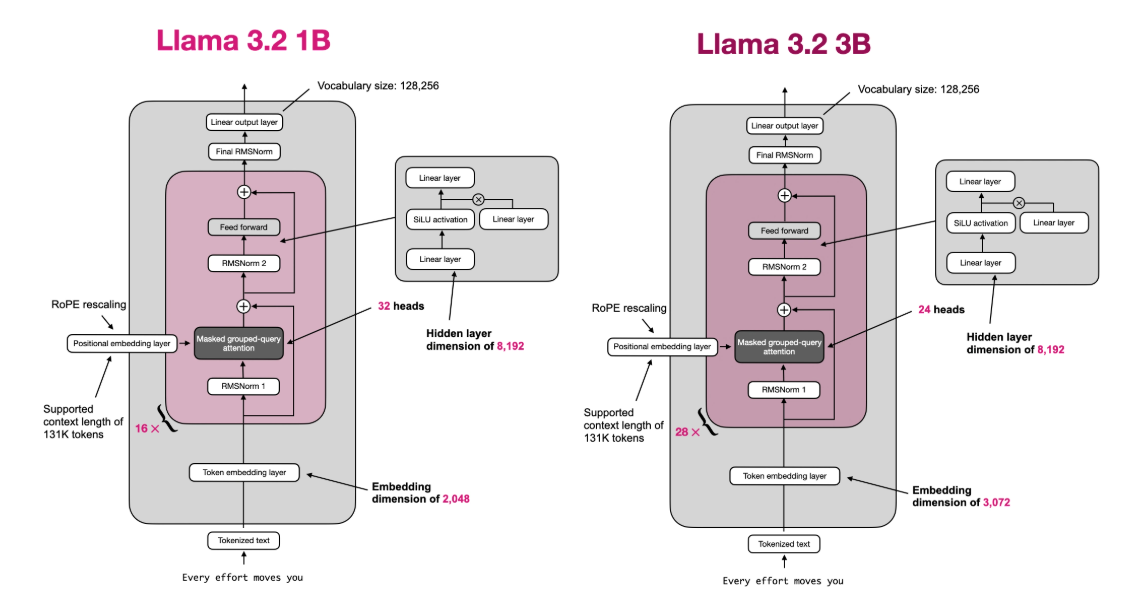

- focus on the code to implement the Llama 3.2 1B and 3B LLMs

- about the code:
  1. mapping the Llama 3 architecture onto the model code implemented in [Build A Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch?utm_source=raschka&utm_medium=affiliate&utm_campaign=book_raschka_build_12_12_23&a_aid=raschka&a_bid=4c2437a0&chan=mm_github) book
  2. the tokenizer code is inspired by the original [Llama 3 tokenizer code](https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py), which Meta AI used to extend the Tiktoken GPT-4 tokenizer
  3. the RoPE rescaling section is inspired by the [_compute_llama3_parameters function](https://github.com/huggingface/transformers/blob/5c1027bf09717f664b579e01cbb8ec3ef5aeb140/src/transformers/modeling_rope_utils.py#L329-L347) in the transformers library

In [2]:
from importlib.metadata import version

pkgs = [
    "blobfile",         # to download pretrained weights
    "huggingface_hub",  # to download pretrained weights
    "tiktoken",         # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

blobfile version: 3.0.0
huggingface_hub version: 0.33.0
tiktoken version: 0.9.0
torch version: 2.6.0+cu124


# 1. Architecture

In [3]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.fc1 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc2 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc3 = nn.Linear(config["hidden_dim"],
                         config["emb_dim"],
                         dtype=config["dtype"],
                         bias=False)

  def forward(self, x):
    x_fc1 = self.fc1(x)
    x_silu = nn.functional.silu(x_fc1)
    x_fc2 = self.fc2(x)
    x_swiglu = x_silu * x_fc2
    return self.fc3(x_swiglu)

In [4]:
def precompute_rope_params(head_dim,
                           theta_base=10_000,
                           context_length=4096,
                           freq_config=None):
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # (Eq. 1) compute the inverse frequencies
  # theta_i = 10000 ^ (-2(i-1)/dim) for i = 1, 2, ..., dim/2
  inv_freq = 1.0 / (
      theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))

  if freq_config is not None:
    low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
    high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

    wavelen = 2 * torch.pi / inv_freq

    inv_freq_llama = torch.where(
        wavelen > low_freq_wavelen,
        inv_freq / freq_config["factor"],
        inv_freq
    )

    smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
        freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
    )

    smooth_inv_freq = (
        (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
    )

    is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
    inv_freq_llama = torch.where(is_medium_freq,
                                 smooth_inv_freq,
                                 inv_freq_llama)
    inv_freq = inv_freq_llama

  # generate position indices
  positions = torch.arange(context_length)

  # compute the angles
  # positions -> row vector
  # inv_freq -> column vector
  angles = positions[:, None] * inv_freq[None, :] # (context_length, head_dim // 2)

  # expand angles to match the head_dim
  angles = torch.cat([angles, angles], dim=1) # (context_length, head_dim)

  # precompute sine and cosine
  cos = torch.cos(angles)
  sin = torch.sin(angles)

  return cos, sin



def compute_rope(x, cos, sin):
  # x -> (batch_size, num_heads, seq_len, head_dim)
  batch_size, num_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # split x into two subspaces
  x1 = x[..., :head_dim // 2] # first half
  x2 = x[..., head_dim // 2 :] # second half

  # adjust sin and cos shapes
  cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

  # apply the rotary transformation
  rotated = torch.cat((-x2, x1), dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  # It's ok to use lower-precision after applying cos and sin rotation
  return x_rotated.to(dtype=x.dtype)

In [5]:
class GroupedQueryAttention(nn.Module):
  def __init__(
      self,
      input_embedding_dim,
      output_embedding_dim,
      num_heads,
      num_kv_groups,
      dtype=None,
      ):
    super().__init__()
    assert output_embedding_dim % num_heads == 0, "output_embedding_dim must be divisible by num_heads"
    assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

    self.output_embedding_dim = output_embedding_dim
    self.num_heads = num_heads
    self.head_dim = output_embedding_dim // num_heads


    self.W_key = nn.Linear(input_embedding_dim,
                           num_kv_groups * self.head_dim,
                           bias=False,
                           dtype=dtype)
    self.W_value = nn.Linear(input_embedding_dim,
                           num_kv_groups * self.head_dim,
                           bias=False,
                           dtype=dtype)
    self.num_kv_groups = num_kv_groups
    self.group_size = num_heads // num_kv_groups


    self.W_query = nn.Linear(input_embedding_dim,
                            output_embedding_dim,
                            bias=False,
                            dtype=dtype)
    self.output_projection = nn.Linear(output_embedding_dim,
                                        output_embedding_dim,
                                        bias=False,
                                        dtype=dtype) # to combine head outputs


  def forward(self,
              inputs,
              mask=None,
              cos=None,
              sin=None):
    batch, num_tokens, input_embedding_dim = inputs.shape

    # qkv shapes : (batch, num_tokens, output_embedding_dim)
    keys = self.W_key(inputs)
    values = self.W_value(inputs)
    queries = self.W_query(inputs)


    # kv shapes : (batch, num_tokens, num_kv_groups, head_dim)
    keys = keys.view(batch, num_tokens, self.num_kv_groups, self.head_dim)
    values = values.view(batch, num_tokens, self.num_kv_groups, self.head_dim)
    # q shape : (batch, num_tokens, num_heads, head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)


    # kv shapes : (batch, num_kv_groups, num_tokens, head_dim)
    # q shape : (batch, num_heads, num_tokens, head_dim)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)
    queries = queries.transpose(1, 2)


    # Apply RoPE
    if cos is not None:
      keys = compute_rope(keys, cos, sin)
      queries = compute_rope(queries, cos, sin)


    # Expand keys and values to match the number of heads
    # kv shapes : (batch, num_heads, num_tokens, head_dim)
    keys = keys.repeat_interleave(self.group_size, dim=1)
    values = values.repeat_interleave(self.group_size, dim=1)
    # For example, before repeat_interleave along dim=1 (query groups):
    #   [K1, K2]
    # After repeat_interleave (each query group is repeated group_size times):
    #   [K1, K1, K2, K2]
    # If we used regular repeat instead of repeat_interleave, we'd get:
    #   [K1, K2, K1, K2]


    # compute attention scores for each head with a causal mask
    # shape : (batch, num_heads, num_tokens, num_tokens)
    attention_scores = queries @ keys.transpose(2, 3)


    # Create mask on the fly
    if mask is None:
      mask = torch.triu(torch.ones(num_tokens,
                                   num_tokens,
                                   device=inputs.device,
                                   dtype=torch.bool,
                                   ),
                        diagonal=1)


    # use the mask to fill attention scores
    attention_scores.masked_fill_(mask, - torch.inf)


    # compute attention weights
    masked_attention_weight = torch.softmax(
        attention_scores / (keys.shape[-1] ** 0.5),
        dim=-1)
    assert keys.shape[-1] == self.head_dim


    # compute context vectors
    # shape : (batch, num_tokens, num_heads, head_dim)
    context_vector = (masked_attention_weight @ values).transpose(1, 2)


    # combine heads, where self.d_out = self.num_heads * self.head_dim
    # shape : (batch, num_tokens, output_embedding_dim)
    context_vector = context_vector.contiguous().view(
        batch, num_tokens, self.output_embedding_dim)


    # linear projection (optional)
    context_vector = self.output_projection(context_vector)


    return context_vector

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = GroupedQueryAttention(input_embedding_dim=config["emb_dim"],
                                               output_embedding_dim=config["emb_dim"],
                                               num_heads=config["n_heads"],
                                               num_kv_groups=config["num_kv_groups"],   # NEW
                                               dtype=config["dtype"],
                                               )
        self.feed_forward = FeedForward(config)
        self.norm1 = nn.RMSNorm(config["emb_dim"],
                                eps=1e-5,
                                dtype=config["dtype"])
        self.norm2 = nn.RMSNorm(config["emb_dim"],
                                eps=1e-5,
                                dtype=config["dtype"])


    def forward(self, x, mask=None, cos=None, sin=None):
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE


        # skip connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x, mask, cos, sin)  # shape: [batch_size, num_tokens, emb_size]
        x = shortcut + x  # skip connection


        # skip connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = shortcut + x  # skip connection

        return x

In [7]:
class Llama3Model(nn.Module):
    def __init__(self, config):
        super().__init__()


        # main model parameters
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"],
                                      dtype=config["dtype"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = nn.RMSNorm(config["emb_dim"],
                                     eps=1e-5,
                                     dtype=config["dtype"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False,
                                  dtype=config["dtype"])

        # reusuable utilities
        cos, sin = precompute_rope_params(
            head_dim=config["emb_dim"] // config["n_heads"],
            theta_base=config["rope_base"],
            context_length=config["context_length"],
            freq_config=config["rope_freq"]
        )

        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        self.config = config

    def forward(self, input_token):
        token_embeds = self.token_emb(input_token)
        x = token_embeds

        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens,
                                     num_tokens,
                                     device=x.device,
                                     dtype=torch.bool),
                          diagonal=1)

        for block in self.transformer_blocks:
            x = block(x, mask, self.cos, self.sin)

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.config["dtype"]))

        return logits

# 2. Initialize model

- The models configurations:

In [8]:
# Llama 3.2 1B

LLAMA32_CONFIG = {
    "vocab_size": 128_256,           # Vocabulary size
    "context_length": 131_072,       # Context length that was used to train the model
    "emb_dim": 2048,                 # Embedding dimension
    "n_heads": 32,                   # Number of attention heads
    "n_layers": 16,                  # Number of layers
    "hidden_dim": 8192,              # Size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,                # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,          # The base in RoPE's "theta"
    "dtype": torch.bfloat16,         # Lower-precision dtype to reduce memory usage
    "rope_freq": {                   # RoPE frequency scaling
        "factor": 32.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

# Llama 3.2 3B

LLAMA32_CONFIG = {
    "vocab_size": 128_256,           # Vocabulary size
    "context_length": 131_072,       # Context length that was used to train the model
    "emb_dim": 3072,                 # Embedding dimension
    "n_heads": 24,                   # Number of attention heads
    "n_layers": 28,                  # Number of layers
    "hidden_dim": 8192,              # Size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,                # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,          # The base in RoPE's "theta"
    "dtype": torch.bfloat16,         # Lower-precision dtype to reduce memory usage
    "rope_freq": {                   # RoPE frequency scaling
        "factor": 32.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

LLAMA_SIZE_STR = "1B" if LLAMA32_CONFIG["emb_dim"] == 2048 else "3B"

In [9]:
import time
initialization_start_time = time.time()

model = Llama3Model(LLAMA32_CONFIG)

initialization_end_time = time.time()
runtime_in_seconds = initialization_end_time - initialization_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Initialization runtime: {int(minutes)} min {seconds:.2f} sec")

Initialization runtime: 0 min 49.59 sec


In [10]:
!pip install torchinfo

In [11]:
from torchinfo import summary

summary(
    model,
    input_size=(1, 128),#LLAMA32_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Trainable
Llama3Model (Llama3Model)                                    [1, 128]                  [1, 128, 128256]          --                        True
├─Embedding (token_emb): 1-1                                 [1, 128]                  [1, 128, 3072]            394,002,432               True
├─Sequential (transformer_blocks): 1-2                       --                        --                        --                        True
│    └─TransformerBlock (0): 2-1                             [1, 128, 3072]            [1, 128, 3072]            --                        True
│    │    └─RMSNorm (norm1): 3-1                             [1, 128, 3072]            [1, 128, 3072]            3,072                     True
│    │    └─GroupedQueryAttention (attention): 3-2           [1, 128, 3072]            [1, 128, 3072]            25,165,824        

- The following is expected to print True to confirm buffers are reused instead of being (wastefully) recreated:

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.token_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 3,606,752,256

Total number of unique parameters: 3,212,749,824


In [13]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 27.00 GB
bfloat16: 13.50 GB


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

# 3. Load tokenizer

In [15]:
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    """Thin wrapper around tiktoken that keeps track of Llama-3 special IDs."""
    def __init__(self, model_path):
        if not os.path.isfile(model_path):
            raise FileNotFoundError(model_path)

        mergeable = load_tiktoken_bpe(model_path)

        # hard-coded from Meta's tokenizer.json
        self.special = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special.update({f"<|reserved_{i}|>": 128002 + i
                             for i in range(256)
                             if 128002 + i not in self.special.values()})

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)"
                    r"|[^\r\n\p{L}\p{N}]?\p{L}+"
                    r"|\p{N}{1,3}"
                    r"| ?[^\s\p{L}\p{N}]+[\r\n]*"
                    r"|\s*[\r\n]+"
                    r"|\s+(?!\S)"
                    r"|\s+",
            mergeable_ranks=mergeable,
            special_tokens=self.special,
        )

    def encode(self, text, bos=False, eos=False):
        ids = ([self.special["<|begin_of_text|>"]] if bos else []) \
              + self.model.encode(text)
        if eos:
            ids.append(self.special["<|end_of_text|>"])
        return ids

    def decode(self, ids):
        return self.model.decode(ids)




class ChatFormat:

    def __init__(self, tokenizer: Tokenizer, *,
                 default_system="You are a helpful assistant."):
        self.tok = tokenizer
        self.default_system = default_system

    def _header(self, role):
        """Encode <|start_header_id|>role<|end_header_id|>\n\n"""
        return (
            [self.tok.special["<|start_header_id|>"]]
            + self.tok.encode(role)
            + [self.tok.special["<|end_header_id|>"]]
            + self.tok.encode("\n\n")
        )

    def encode(self, user_message, system_message=None):
        sys_msg = system_message if system_message is not None else self.default_system

        ids = [self.tok.special["<|begin_of_text|>"]]

        # system
        ids += self._header("system")
        ids += self.tok.encode(sys_msg)
        ids += [self.tok.special["<|eot_id|>"]]

        # user
        ids += self._header("user")
        ids += self.tok.encode(user_message)
        ids += [self.tok.special["<|eot_id|>"]]

        # assistant header (no content yet)
        ids += self._header("assistant")

        return ids

-  since the Llama 3.2 family is distinct from the Llama 3.1 family, you'd have to go to the [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B) repository and acknowledge the license terms for your Hugging Face access token to work for the download

- For simplicity, we only load the base model below, but there's also an instruction-finetuned version you can use by replacing `"meta-llama/Llama-3.2-1B"` with `"meta-llama/Llama-3.2-1B-Instruct"`

In [16]:
!pip install huggingface_hub dotenv

In [17]:
from huggingface_hub import login
from google.colab import userdata
import os

huggingface_key = userdata.get("HF_ACCESS_TOKEN")

login(token=huggingface_key)

In [18]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",
    filename="original/tokenizer.model",
    local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"
)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [19]:
tokenizer = Tokenizer(tokenizer_file_path)
chat_tokenizer = ChatFormat(tokenizer)

# 4. Load pretrained weights

In [20]:
def assign(left, right, tensor_name="unknown"):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")

    if isinstance(right, torch.Tensor):
        return torch.nn.Parameter(right.clone().detach())
    else:
        return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    model.token_emb.weight = assign(model.token_emb.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")

    for l in range(param_config["n_layers"]):

        # Load attention weights
        model.transformer_blocks[l].attention.W_query.weight = assign(
            model.transformer_blocks[l].attention.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight"
        )
        model.transformer_blocks[l].attention.W_key.weight = assign(
            model.transformer_blocks[l].attention.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight"
        )
        model.transformer_blocks[l].attention.W_value.weight = assign(
            model.transformer_blocks[l].attention.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight"
        )
        model.transformer_blocks[l].attention.output_projection.weight = assign(
            model.transformer_blocks[l].attention.output_projection.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight"
        )
        model.transformer_blocks[l].norm1.weight = assign(
            model.transformer_blocks[l].norm1.weight,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight"
        )

        # Load FeedForward weights
        model.transformer_blocks[l].feed_forward.fc1.weight = assign(
            model.transformer_blocks[l].feed_forward.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight"
        )
        model.transformer_blocks[l].feed_forward.fc2.weight = assign(
            model.transformer_blocks[l].feed_forward.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight"
        )
        model.transformer_blocks[l].feed_forward.fc3.weight = assign(
            model.transformer_blocks[l].feed_forward.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight"
        )
        model.transformer_blocks[l].norm2.weight = assign(
            model.transformer_blocks[l].norm2.weight,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight"
        )

    # Load output layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"], "model.norm.weight")

    if "lm_head.weight" in params.keys():
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"], "lm_head.weight")
    else:
        model.out_head.weight = assign(model.out_head.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")
        print("Model uses weight tying.")

In [21]:
from safetensors.torch import load_file


if LLAMA_SIZE_STR == "1B":
    weights_file = hf_hub_download(
        repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",
        filename="model.safetensors",
        local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"
    )
    combined_weights = load_file(weights_file)


else:
    combined_weights = {}
    for i in range(1, 3):
        weights_file = hf_hub_download(
            repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",
            filename=f"model-0000{i}-of-00002.safetensors",
            local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"
        )
        current_weights = load_file(weights_file)
        combined_weights.update(current_weights)


load_weights_into_llama(model, LLAMA32_CONFIG, combined_weights)
model.to(device)
del combined_weights  # free up memory

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Model uses weight tying.


In [22]:
print("Weight tying:", torch.equal(model.token_emb.weight,
                                   model.out_head.weight))

Weight tying: True


# 5. Generate text

In [23]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text)
  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor



def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [29]:
import time


PROMPT = "What is cohomology?"

torch.manual_seed(211)

start = time.time()

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(PROMPT, tokenizer).to(device),
    max_new_tokens=1000,
    context_size=LLAMA32_CONFIG["context_length"],
    top_k=1,
    temperature=0.
)

print(f"Time: {time.time() - start:.2f} sec")

if torch.cuda.is_available():
    max_mem_bytes = torch.cuda.max_memory_allocated()
    max_mem_gb = max_mem_bytes / (1024 ** 3)
    print(f"Max memory allocated: {max_mem_gb:.2f} GB")

output_text = token_ids_to_text(token_ids, tokenizer)


def clean_text(text, header_end="assistant<|end_header_id|>\n\n"):
    # Find the index of the first occurrence of "<|end_header_id|>"
    index = text.find(header_end)

    if index != -1:
        # Return the substring starting after "<|end_header_id|>"
        return text[index + len(header_end):].strip()  # Strip removes leading/trailing whitespace
    else:
        # If the token is not found, return the original text
        return text

Time: 41.47 sec
Max memory allocated: 7.49 GB


In [30]:
print("\n\nOutput text:\n\n", output_text)



Output text:

 What is cohomology? Cohomology is a branch of algebraic topology that studies the cohomology groups of a topological space. It is a way of measuring the "holes" in a space, and it has many applications in mathematics and physics. In essence, cohomology is a way of analyzing the "obstructions" to deforming a space into a simpler form, such as a sphere or a disk. The cohomology groups of a space are defined as the quotient groups of the kernel of a coboundary operator applied to a chain complex of the space. The coboundary operator is a linear map that takes a chain and produces another chain, and the kernel of this map is the set of all chains that can be "reached" from a given chain by applying the coboundary operator repeatedly. The cohomology groups are then defined as the quotient groups of the kernel of the coboundary operator by the image of the coboundary operator. In other words, cohomology is a way of measuring the "obstructions" to deforming a space into a sim

In [31]:
print("\n\nOutput text:\n\n", clean_text(output_text))



Output text:

 What is cohomology? Cohomology is a branch of algebraic topology that studies the cohomology groups of a topological space. It is a way of measuring the "holes" in a space, and it has many applications in mathematics and physics. In essence, cohomology is a way of analyzing the "obstructions" to deforming a space into a simpler form, such as a sphere or a disk. The cohomology groups of a space are defined as the quotient groups of the kernel of a coboundary operator applied to a chain complex of the space. The coboundary operator is a linear map that takes a chain and produces another chain, and the kernel of this map is the set of all chains that can be "reached" from a given chain by applying the coboundary operator repeatedly. The cohomology groups are then defined as the quotient groups of the kernel of the coboundary operator by the image of the coboundary operator. In other words, cohomology is a way of measuring the "obstructions" to deforming a space into a sim

In [27]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")
print(f"Device: {device} ")

Notebook runtime: 4 min 27.45 sec
Device: cuda 


In [28]:
!nvidia-smi

Fri Jun 27 09:19:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0            344W /  400W |   33329MiB /  40960MiB |     86%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----